# Homework 4: Modeling Text Data

### Team Member 1:
* UNI: xl2601
* Name: Xinwei Li

### Team Member 2 [optional]:
* UNI: xl2602
* Name: Lucy Lu


You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

In [1]:
# Add your code for task 1 here. You may use multiple cells. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline
plt.rcParams["figure.dpi"] = 100

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
raw_data = pd.read_csv('Vision_Zero_Entry.csv')

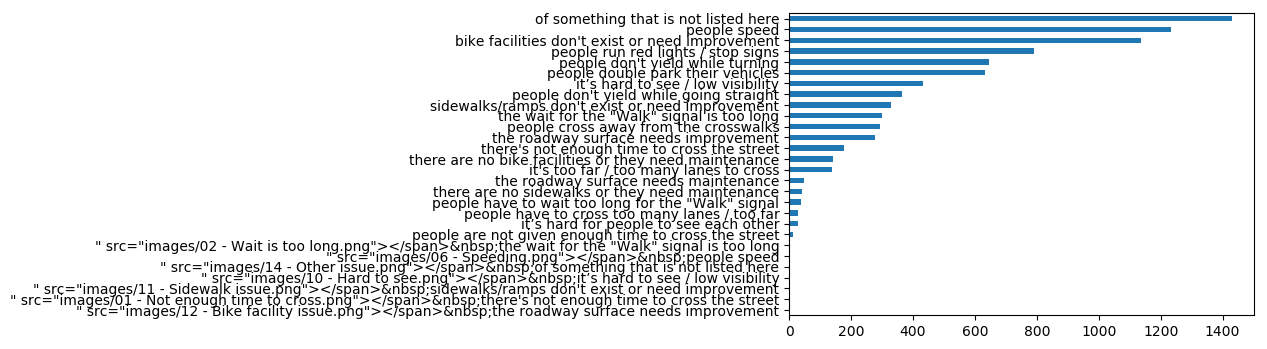

In [3]:
raw_data.REQUESTTYPE.value_counts(ascending=True).plot(kind='barh')

In [4]:
raw_data['REQUESTTYPE'] = raw_data.REQUESTTYPE.str.extract('([^;]+;|)(.+)', expand=True)[1]

In [5]:
raw_data_select = raw_data[['REQUESTTYPE', 'COMMENTS']]
raw_data_select.shape

(8534, 2)

In [6]:
raw_data_select_nona = raw_data_select[~pd.isnull(raw_data_select.COMMENTS)]
raw_data_select_nona.shape

(6647, 2)

In [7]:
raw_data_select_nona_nodup = raw_data_select_nona.drop_duplicates()
raw_data_select_nona_nodup.shape

(6460, 2)

In [8]:
raw_data_select_nona_nodup.duplicated().any()

False

In [9]:
raw_data_select_nona_nodup.REQUESTTYPE.unique().shape

(21,)

In [10]:
np.sort(raw_data_select_nona_nodup.REQUESTTYPE.unique())

array(["bike facilities don't exist or need improvement",
       "it's too far / too many lanes to cross",
       'it’s hard for people to see each other',
       'it’s hard to see / low visibility',
       'of something that is not listed here',
       'people are not given enough time to cross the street',
       'people cross away from the crosswalks',
       "people don't yield while going straight",
       "people don't yield while turning",
       'people double park their vehicles',
       'people have to cross too many lanes / too far',
       'people have to wait too long for the "Walk" signal',
       'people run red lights / stop signs', 'people speed',
       "sidewalks/ramps don't exist or need improvement",
       'the roadway surface needs improvement',
       'the roadway surface needs maintenance',
       'the wait for the "Walk" signal is too long',
       'there are no bike facilities or they need maintenance',
       'there are no sidewalks or they need maintenance'

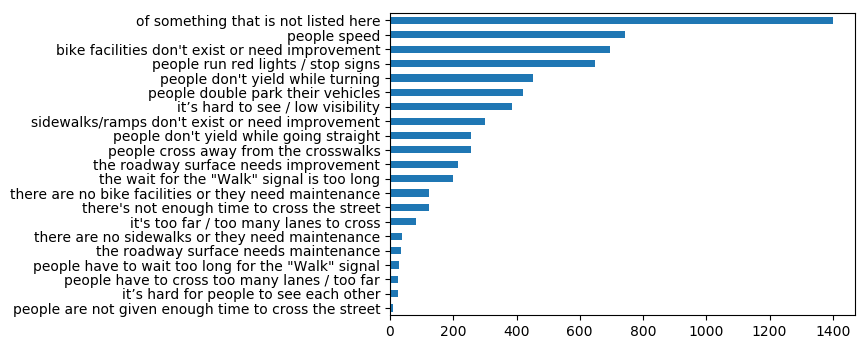

In [11]:
raw_data_select_nona_nodup.REQUESTTYPE.value_counts(ascending=True).plot(kind='barh')

In [12]:
clean_type = {"REQUESTTYPE": {"it’s hard to see / low visibility": "it’s hard for people to see each other",
                              "the roadway surface needs improvement": "the roadway surface needs maintenance",
                              "there are no bike facilities or they need maintenance": "bike facilities don't exist or need improvement",
                              'people have to wait too long for the "Walk" signal': 'the wait for the "Walk" signal is too long',
                              "sidewalks/ramps don't exist or need improvement": "there are no sidewalks or they need maintenance",
                              "people are not given enough time to cross the street": "there's not enough time to cross the street",
                              "it's too far / too many lanes to cross": "there's not enough time to cross the street",
                              "people have to cross too many lanes / too far": "there's not enough time to cross the street"
                             }}

clean_data = raw_data_select_nona_nodup.replace(clean_type)

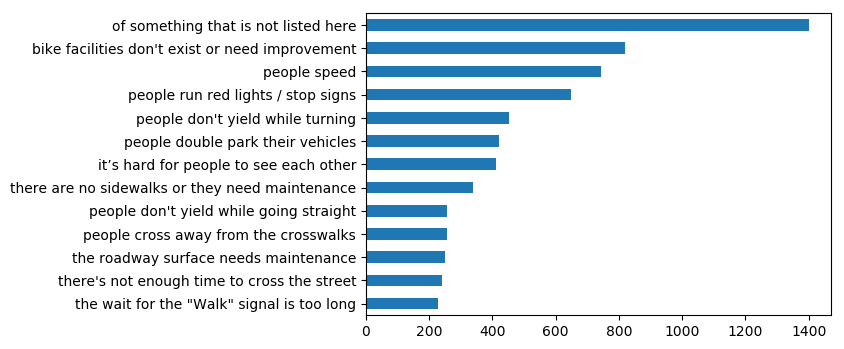

In [13]:
clean_data.REQUESTTYPE.value_counts(ascending=True).plot(kind='barh')

In [14]:
clean_data.REQUESTTYPE.unique().shape

(13,)

In [15]:
text = clean_data.COMMENTS.tolist()
target = clean_data.REQUESTTYPE.tolist()

In [16]:
text_train, text_test, target_train, target_test = train_test_split(text, target, stratify=target, random_state=45)

# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

In [17]:
# Add your code for task 2 here. You may use multiple cells. 
import itertools
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

In [18]:
vect = CountVectorizer(stop_words='english', token_pattern=r"\b\w+\b")
text_train_vect = vect.fit_transform(text_train)
text_test_vect = vect.transform(text_test)

In [19]:
lr = LogisticRegressionCV().fit(text_train_vect, target_train)

In [20]:
lr.score(text_test_vect, target_test)

0.58328173374613002

In [21]:
pred = lr.predict(text_test_vect)

In [22]:
f1_score(target_test, pred, average='macro')

0.51668992687713322

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[157   1  30   0   0   1   5   0   2   5   0   2   1]
 [  2  44  30   0   6   3   0   5  12   0   0   1   0]
 [ 30   8 215  10   2   7  13  14  21   8   7  15   0]
 [  2   1  27  16   1   3   0   3   3   3   1   4   0]
 [  4   2  22   1   7   7   0   6  10   0   2   3   0]
 [  4   5  31   1   3  50   0   9   6   0   4   0   0]
 [  3   3  27   0   0   0  69   1   1   0   0   1   0]
 [  2   3  24   0   0   4   0 119   5   0   2   1   2]
 [  6   4  17   0   1   2   1  10 141   0   1   2   0]
 [ 14   0  10   0   0   1   0   0   0  34   1   3   0]
 [  0   0   9   0   0   2   0   4   1   1  37   1   2]
 [  5   0  20   2   0   0   0   0   5   2   0  51   0]
 [  2   4  25   2   0   3   0   0   8   1   9   4   2]]


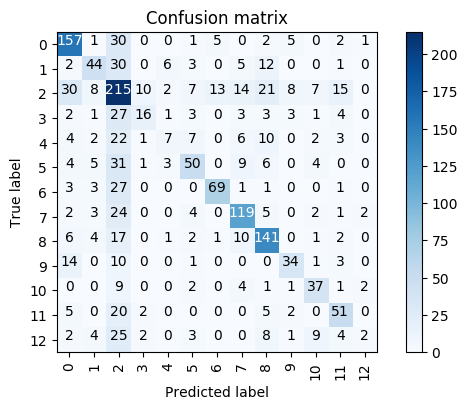

In [24]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(target_test, pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(13), title='Confusion matrix')

In [25]:
print(classification_report(target_test, pred))

                                                 precision    recall  f1-score   support

bike facilities don't exist or need improvement       0.68      0.77      0.72       204
         it’s hard for people to see each other       0.59      0.43      0.49       103
           of something that is not listed here       0.44      0.61      0.51       350
          people cross away from the crosswalks       0.50      0.25      0.33        64
        people don't yield while going straight       0.35      0.11      0.17        64
               people don't yield while turning       0.60      0.44      0.51       113
              people double park their vehicles       0.78      0.66      0.72       105
             people run red lights / stop signs       0.70      0.73      0.71       162
                                   people speed       0.66      0.76      0.70       185
          the roadway surface needs maintenance       0.63      0.54      0.58        63
     the wait for th

### One mistake is that our model mistakenly classify lots of comments as "of something that is not listed here". There are some comments belong to "of something that is not listed here" type are really similar to the comments in other types, which cause the misclassifications.

# Task3 - Model 2 [30 points]

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

In [26]:
# Add your code for task 3 here. You may use multiple cells.

### N-grams
Since grid search takes long time, we will save the best model and comment grid search code out for Travis run go through.

#### Best score
Train:0.56550012811237405

Test:0.5830348269772434


#### Best params

{'countvectorizer\__min_df': 2,
 'countvectorizer\__ngram_range': (1, 3),
 'logisticregression\__C': 1}

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#param_grid = {"logisticregression__C": [100, 10, 1, 0.1, 0.001],"countvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3), (1, 5),(2, 3), (2, 5), (3, 8), (5, 5)],"countvectorizer__min_df": [2, 3, 4]}
#grid_ng = GridSearchCV(make_pipeline(CountVectorizer(), LogisticRegression()), param_grid=param_grid, cv=5, scoring="f1_macro", n_jobs=-1)

In [28]:
#grid_ng.fit(text_train, target_train)

In [29]:
#grid_ng.best_score_

In [30]:
#grid_ng.best_params_

In [31]:
#grid_ng.score(text_test, target_test)

### Character n-grams
Since grid search takes long time, we will save the best model and comment grid search code out for Travis run go through.

#### Best score
Train:0.55877451579511994

Test:0.58175768783207149

#### Best params
{'countvectorizer\__min_df': 6,
 'countvectorizer\__ngram_range': (3, 8),
 'logisticregression\__C': 10,
 'normalizer': Normalizer(copy=True, norm='l2')}

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer

#param_grid = {"logisticregression__C": [100, 10, 1, 0.1, 0.001], "countvectorizer__ngram_range": [(3, 8), (3, 10), (4, 10)],"countvectorizer__min_df": [5, 6],"normalizer": [None, Normalizer()]}
#grid_char_norm = GridSearchCV(make_pipeline(CountVectorizer(analyzer="char_wb"), Normalizer(), LogisticRegression()),param_grid=param_grid, cv=5, scoring="f1_macro", n_jobs=-1)

In [33]:
#grid_char_norm.fit(text_train, target_train)

In [34]:
#grid_char_norm.best_score_

In [35]:
#grid_char_norm.best_params_

In [36]:
#grid_char_norm.score(text_test, target_test)

### Possibly domain-specific features (Using length of comment as domain-specific feature)

In [37]:
vect=CountVectorizer(min_df=2, ngram_range=(1, 3))
text_train_vect = vect.fit_transform(text_train)
text_test_vect = vect.transform(text_test)

In [38]:
from scipy.sparse import csc_matrix,hstack
#domain=[]
#for row in text_train:
    #domain.append(len(row))
#domain=csc_matrix(np.asarray(domain).reshape(-1,1))
#text_train_vect=hstack([text_train_vect,domain])

In [39]:
#domain=[]
#for row in text_test:
    #domain.append(len(row))
#domain=csc_matrix(np.asarray(domain).reshape(-1,1))
#text_test_vect=hstack([text_test_vect,domain])

In [40]:
#lr = LogisticRegressionCV().fit(text_train_vect,target_train)

In [41]:
#pred = lr.predict(text_test_vect)

### F1 Score：0.57374928193646624 

In [42]:
#f1_score(target_test, pred, average='macro')

# Task4 - Visualize Results [10 points]

Visualize results of the tuned model (classification results, confusion matrix, important features, example mistakes).

In [43]:
# Add your code for task 4 here. You may use multiple cells.

### Tuned Model

In [44]:
pipe_ng = make_pipeline(CountVectorizer(min_df=2, ngram_range=(1, 3)), LogisticRegression(C=1))
pipe_ng.fit(text_train, target_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [45]:
pipe_char_norm = make_pipeline(CountVectorizer(analyzer="char_wb", min_df=6, ngram_range=(3, 8)), 
                               Normalizer(), LogisticRegression(C=10))
pipe_char_norm.fit(text_train, target_train)

/Users/lucylu/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=6,
        ngram_range=(3, 8), preprocessor=None, stop_words=None,...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

### Classification results

In [46]:
pred_ng=pipe_ng.predict(text_test)

In [47]:
print(classification_report(target_test, pred_ng))

                                                 precision    recall  f1-score   support

bike facilities don't exist or need improvement       0.68      0.77      0.72       204
         it’s hard for people to see each other       0.69      0.58      0.63       103
           of something that is not listed here       0.46      0.56      0.50       350
          people cross away from the crosswalks       0.52      0.47      0.49        64
        people don't yield while going straight       0.47      0.22      0.30        64
               people don't yield while turning       0.57      0.45      0.50       113
              people double park their vehicles       0.82      0.69      0.75       105
             people run red lights / stop signs       0.70      0.73      0.72       162
                                   people speed       0.70      0.76      0.73       185
          the roadway surface needs maintenance       0.63      0.54      0.58        63
     the wait for th

In [48]:
pred_char=pipe_char_norm.predict(text_test)

/Users/lucylu/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [49]:
print(classification_report(target_test, pred_char))

                                                 precision    recall  f1-score   support

bike facilities don't exist or need improvement       0.68      0.78      0.72       204
         it’s hard for people to see each other       0.66      0.56      0.61       103
           of something that is not listed here       0.48      0.59      0.53       350
          people cross away from the crosswalks       0.54      0.45      0.49        64
        people don't yield while going straight       0.45      0.27      0.33        64
               people don't yield while turning       0.61      0.47      0.53       113
              people double park their vehicles       0.83      0.70      0.76       105
             people run red lights / stop signs       0.66      0.69      0.67       162
                                   people speed       0.68      0.76      0.72       185
          the roadway surface needs maintenance       0.70      0.62      0.66        63
     the wait for th

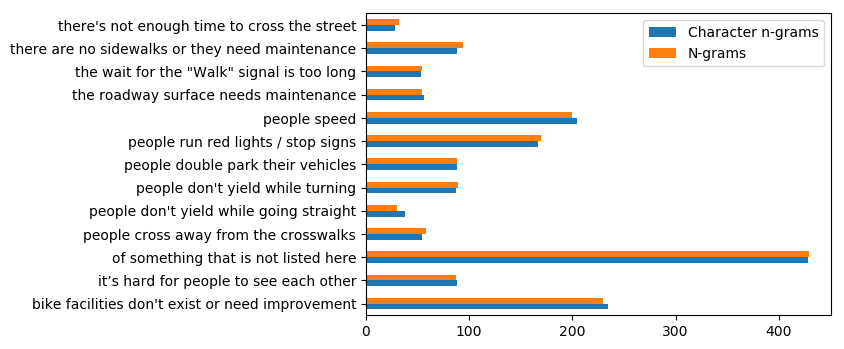

In [50]:
pd.concat([pd.Series(pred_char,name="Character n-grams").value_counts(ascending=True), pd.Series(pred_ng,name="N-grams").value_counts(ascending=True)],axis=1).plot(kind='barh')

### Confusion matrix

In [51]:
pred_ng = pipe_ng.predict(text_test)
pred_char_norm = pipe_char_norm.predict(text_test)

/Users/lucylu/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [52]:
pd.DataFrame({'category':clean_data.REQUESTTYPE.unique().tolist()})

,category
0,bike facilities don't exist or need improvement
1,of something that is not listed here
2,people don't yield while going straight
3,it’s hard for people to see each other
4,people don't yield while turning
5,"the wait for the ""Walk"" signal is too long"
6,there are no sidewalks or they need maintenance
7,people cross away from the crosswalks
8,people double park their vehicles
9,people speed


[[157   0  29   1   0   2   2   0   2   5   1   4   1]
 [  1  60  22   0   5   1   0   2  10   1   0   1   0]
 [ 28  11 196  14   3  12  11  19  19  10   7  15   5]
 [  1   0  20  30   0   3   0   1   2   1   0   4   2]
 [  2   2  20   3  14   7   0   6   7   0   1   2   0]
 [  8   5  28   1   2  51   0   9   4   0   3   0   2]
 [  2   1  27   0   0   0  72   1   1   0   0   1   0]
 [  1   1  25   0   2   6   1 119   6   0   1   0   0]
 [  5   5  20   1   3   2   1   6 140   0   0   1   1]
 [ 15   0   8   0   0   1   0   1   0  34   0   3   1]
 [  0   0   7   2   0   0   1   6   1   1  36   0   3]
 [  6   1  12   4   0   0   0   0   3   2   0  57   0]
 [  4   1  15   2   1   4   0   0   5   0   5   6  17]]


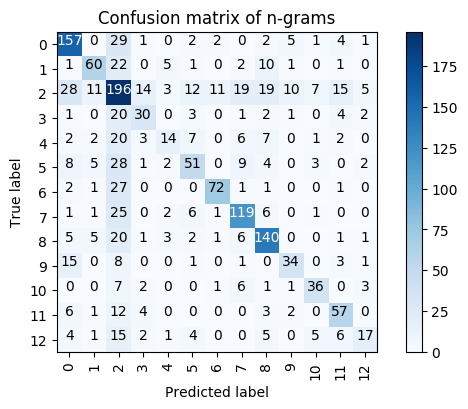

In [53]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(target_test, pred_ng)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(13), title='Confusion matrix of n-grams')

[[159   0  29   0   0   1   4   0   3   4   1   3   0]
 [  3  58  21   0   5   2   0   3   9   1   0   1   0]
 [ 26  14 206  11   7   7   9  20  20   6   7  14   3]
 [  2   1  19  29   1   2   0   2   1   1   1   3   2]
 [  2   1  14   3  17   6   0   6  11   0   1   2   1]
 [  5   3  29   0   3  53   0  10   3   1   4   0   2]
 [  2   0  29   0   0   0  73   0   0   0   0   1   0]
 [  3   3  28   0   1   5   2 111   6   0   2   0   1]
 [  8   6  11   2   4   4   0   9 140   0   0   1   0]
 [ 14   0   4   2   0   0   0   0   0  39   0   4   0]
 [  0   0   9   1   0   3   0   5   0   1  33   1   4]
 [  8   0  11   5   0   0   0   0   7   2   0  52   0]
 [  3   2  18   1   0   4   0   1   5   1   4   6  15]]


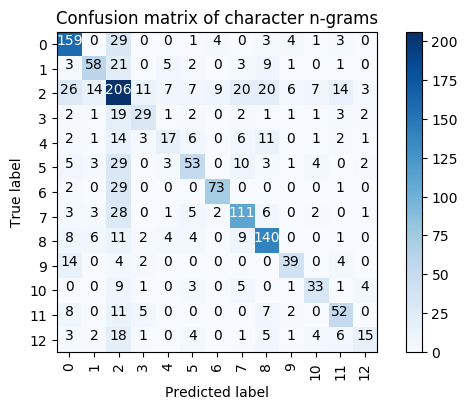

In [54]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(target_test, pred_char_norm)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(13), title='Confusion matrix of character n-grams')

### Features Importance

In [55]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
  
    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=60, ha="right")

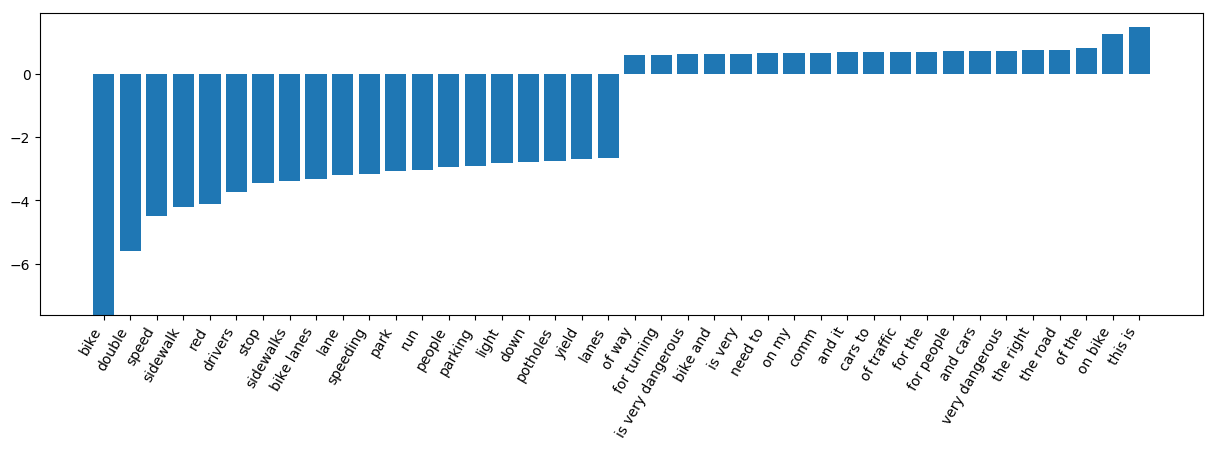

In [56]:
plt.figure(figsize=(15, 4))
plot_important_features(np.sum(pipe_ng.named_steps['logisticregression'].coef_, axis=0), 
                        np.array(pipe_ng.named_steps['countvectorizer'].get_feature_names()), top_n=20)

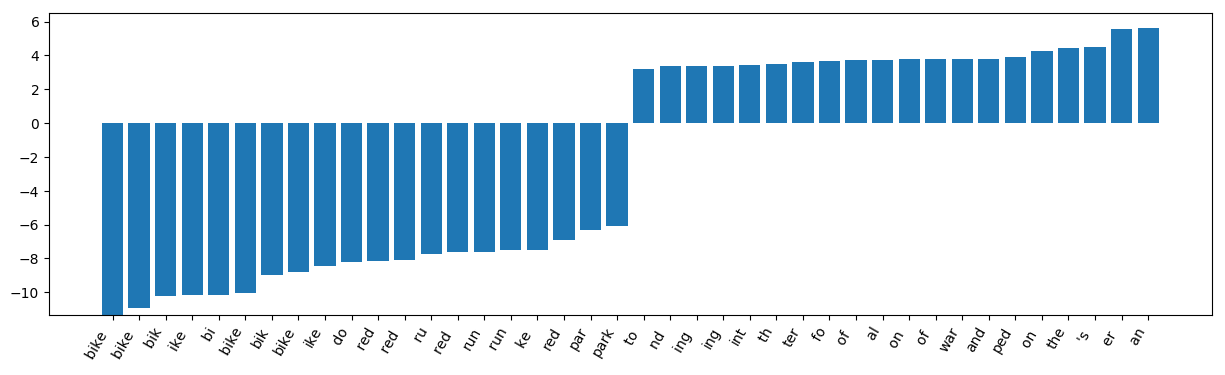

In [57]:
plt.figure(figsize=(15, 4))
plot_important_features(np.sum(pipe_char_norm.named_steps['logisticregression'].coef_, axis=0), 
                        np.array(pipe_char_norm.named_steps['countvectorizer'].get_feature_names()), top_n=20)

### Example mistakes

In [58]:
# Found First 3 Mistakes
mistakes_index=[index for index,check in enumerate(pred_ng!=target_test) if check==True]
comment=pd.Series(np.asarray(text_test)[mistakes_index][:3],name="Comment")
predict_type=pd.Series(pred_ng[mistakes_index][:3],name="Predict Type")
True_type=pd.Series(np.asarray(target_test)[mistakes_index][:3],name="True Type")
mistakes=pd.concat([comment,predict_type,True_type],axis=1)

In [59]:
mistakes

,Comment,Predict Type,True Type
0,"In the afternoons, traffic backs up from New R...",of something that is not listed here,people run red lights / stop signs
1,"We need a stop sign here asap, Ive seen people...",of something that is not listed here,people speed
2,"There is a crosswalk, but visibility is often ...",people don't yield while going straight,it’s hard for people to see each other


In [60]:
mistakes["Comment"].tolist()

['In the afternoons, traffic backs up from New Rutherford Ave on Chelsea St. Traffic coming from Constitution Ave up  Warren and taking a left onto Chelsea end up blocking the intersection due to the backed up traffic stopped in the intersection.',
 'We need a stop sign here asap, Ive seen people almost get run over... its a cross walk but with the amount of pedestrians and kids, its NEEDS a stop sign.',
 'There is a crosswalk, but visibility is often blocked by a delivery truck or other vehicle and pedestrians have to stand far out into the road before they can see and be seen.']

After checking the text of comment, we believed that the cause for these three model mistakes is that the true labels of comment are not appropriate for the comments, and `of something that is not listed here` label actually includes comments which should belong to other types. As you can see, the first comment is unrelated to the red lights or stop signs. Our model classify it as "others" since the expression pattern of this comment is similar to some "not listed" comment. The second comment and third also have nothing to do with people speed or visibility, which means the true labels are inappropriate.

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

In [61]:
# Add your code for task 5 here. You may use multiple cells.

In [62]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=13, max_iter=5,
                                learning_method='online',
                                random_state=0)
tf_vectorizer = CountVectorizer(max_df=0.95,min_df=2,                               
                                stop_words='english')
tf = tf_vectorizer.fit_transform(text)
result_lda=lda.fit_transform(tf)

In [63]:
lda.components_

array([[  0.08,   0.08,   0.08, ...,   0.08,   0.08,   0.08],
       [  0.08,   0.08,   0.08, ...,  50.35,   6.16,   0.08],
       [  0.08,   0.08,   0.08, ...,   0.08,   0.08,   0.08],
       ..., 
       [  0.08,   0.08,  34.18, ...,   0.08,   0.08,  12.96],
       [  0.08,   0.08,   0.08, ...,   0.08,   0.08,   0.08],
       [  0.08,   0.08,   0.08, ...,   0.08,   0.08,   0.08]])

In [64]:
def print_top_words(model, feature_names, n_top_words):
    for topic_id, topic in enumerate(model.components_):
        print('\nTopic No.%d:' % int(topic_id + 1)) 
        print(''.join([feature_names[i] + ' ' + str(round(topic[i], 2))
              +' | ' for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [65]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic No.1:
lot 177.12 | bikers 149.92 | large 108.67 | washington 87.16 | walkers 71.94 | bumps 64.68 | potholes 63.31 | surface 58.03 | avenue 56.17 | south 53.3 | hard 47.0 | construction 43.06 | building 39.65 | given 38.47 | huge 32.48 | roadway 31.59 | harrison 30.54 | west 28.74 | completely 26.77 | biking 26.26 | 

Topic No.2:
lane 1082.98 | bike 952.51 | lanes 521.95 | needs 393.65 | cars 335.69 | left 250.57 | right 235.21 | turn 186.83 | traffic 175.24 | need 165.76 | parking 157.24 | double 148.47 | parked 125.89 | bus 123.13 | bikes 120.91 | people 112.13 | vehicles 111.52 | park 90.6 | straight 84.62 | turning 84.4 | 

Topic No.3:
times 153.43 | stops 77.03 | multiple 75.31 | looking 50.94 | entire 45.56 | circle 36.32 | area 32.99 | island 31.43 | forced 27.02 | problem 25.3 | connect 21.05 | say 17.72 | awful 16.1 | shape 15.79 | recently 13.9 | week 13.38 | minutes 13.1 | car 13.08 | sullivan 13.01 | cummins 12.98 | 

Topic No.4:
waiting 115.62 | time 111.03 | ignore 

### Some topics can be matched to orginal label, for example:
- Topic2 seems match origin class `bike facilities don't exist or need improvement`
- Topic11 may match origin class `people speed`

In [66]:
lda_predic=[]
for doc_id, topic_dist in enumerate(result_lda):
    print('\nComment No.%d:' % int(doc_id))
    topic_order=topic_dist.argsort()[::-1]
    print(topic_order)
    lda_predic.append(topic_order[0])


Comment No.0:
[ 4  5  6  1  9 12 10  3 11  2  0  7  8]

Comment No.1:
[ 1  7  6 11  8  4 10  0 12  9  5  3  2]

Comment No.2:
[11  6 12  4  1  9 10  3  7  5  8  0  2]

Comment No.3:
[11  6 10  4  7 12  8  1  5  9  3  0  2]

Comment No.4:
[ 0 11  1 12  4  6  9 10  3  8  7  2  5]

Comment No.5:
[ 4  6 11  1  5  9 10  8  0  2  7  3 12]

Comment No.6:
[11  5  8 10  6  4  9  1  3  0  7  2 12]

Comment No.7:
[ 9 11  3  4 12 10  5  6  1  8  2  7  0]

Comment No.8:
[ 4 11  7  9  6  1 10  5  8  2  0 12  3]

Comment No.9:
[ 5  1  6 12  4 10 11  2  9  0  7  3  8]

Comment No.10:
[ 4  1  8 10  6 12  5 11  0  9  7  2  3]

Comment No.11:
[12  5 10 11  1  4  6  9  0  2  7  3  8]

Comment No.12:
[12  5 10 11  1  4  6  9  0  2  7  3  8]

Comment No.13:
[ 9  5 11  4  1 10  0 12  3  6  8  2  7]

Comment No.14:
[ 6 11  3 10  9  8  1  4 12  0  5  7  2]

Comment No.15:
[ 0 11  8  6  4 10  1  9 12  3  5  7  2]

Comment No.16:
[ 1  7  0  4  8 11 10  3  6  2  5  9 12]

Comment No.17:
[ 6  1  9 10  4 12 11  8 

In [67]:
lda.components_.shape

(13, 3440)

In [68]:
def plot_important_features_sub(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")

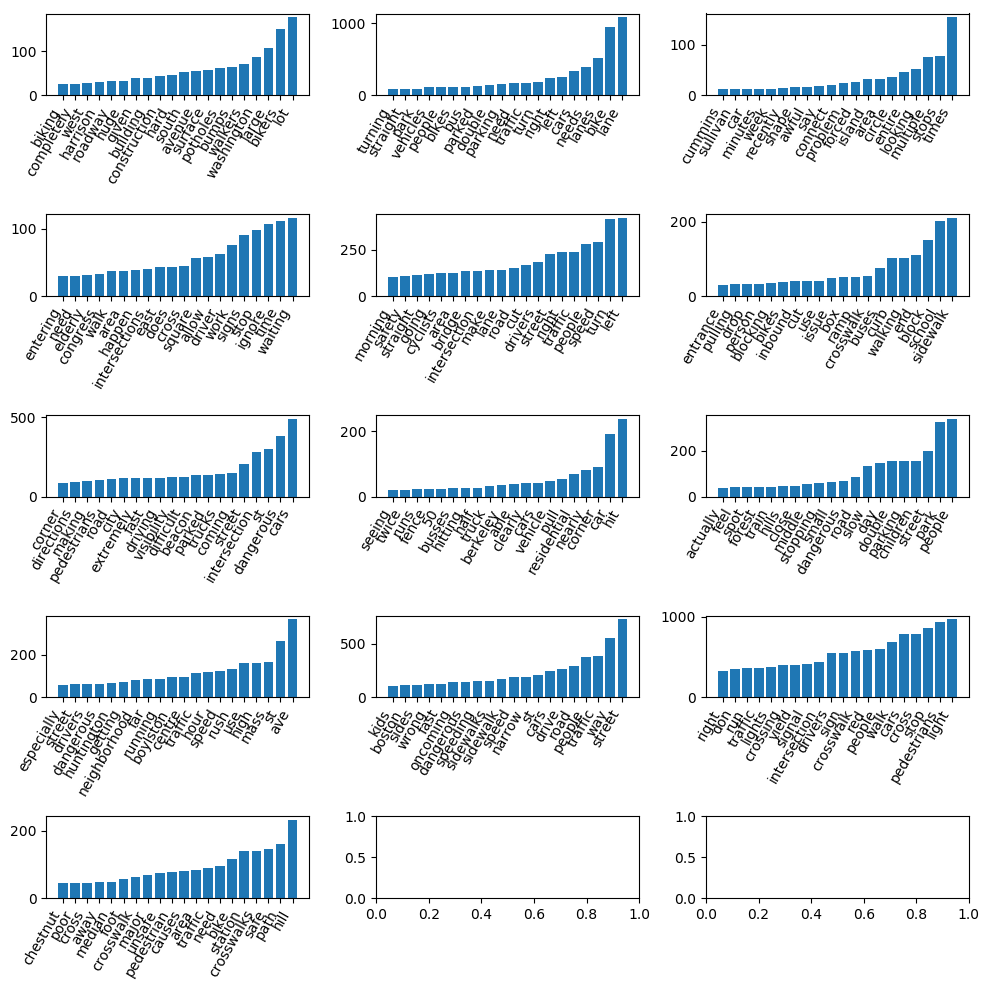

In [69]:
# LDA Topics Visualize
feature_names = np.array(tf_feature_names)
n_components = 13
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lda.components_):
    plot_important_features_sub(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()

In [70]:
# ARI for LDA
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(target,lda_predic)

0.063160941678442425

In [71]:
#NMF
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,ngram_range=(1, 3), stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(text)
nmf = NMF(n_components=13, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

In [72]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, 10)


Topic No.1:
left 2.17 | turn 2.06 | right 1.14 | left turn 0.97 | lane 0.7 | straight 0.6 | turning 0.58 | turn left 0.53 | turn lane 0.44 | left lane 0.38 | 

Topic No.2:
lane 2.8 | bike lane 2.29 | bike 2.2 | need 0.22 | facilities 0.2 | bike facilities 0.2 | right 0.18 | park bike lane 0.18 | park bike 0.18 | markings 0.17 | 

Topic No.3:
street 2.51 | cars 1.99 | traffic 1.07 | dangerous 0.81 | intersection 0.8 | road 0.78 | sidewalk 0.77 | parked 0.68 | coming 0.57 | crossing 0.42 | 

Topic No.4:
yield 1.83 | crosswalk 1.57 | pedestrians 1.43 | yield pedestrians 1.37 | don 1.08 | don yield 0.99 | pedestrians crosswalk 0.76 | don yield pedestrians 0.69 | yield pedestrians crosswalk 0.6 | cars don 0.34 | 

Topic No.5:
stop 2.76 | sign 1.81 | stop sign 1.79 | stop signs 0.41 | stop stop 0.4 | signs 0.35 | run stop 0.33 | run stop sign 0.3 | don stop 0.29 | stop stop sign 0.27 | 

Topic No.6:
red 1.97 | light 1.96 | red light 1.2 | run 1.16 | run red 1.0 | lights 0.7 | run red light 

### Topics that match well with some of the ground truth labels:
Some topics can be matched to orginal label, for example:
- Topic2 and Topic7 together match origin class `bike facilities don't exist or need improvement`
- Topic4 matches two original labels `people don't yield while going straight` and `people don't yield while turning`
- Topic9 matches origin class `people speed`

In [73]:
result_NMF=nmf.transform(tfidf)

In [74]:
NMF_predic=[]
for doc_id, topic_dist in enumerate(result_NMF):
    print('\nComment No.%d:' % int(doc_id))
    topic_order=topic_dist.argsort()[::-1]
    print(topic_order)
    NMF_predic.append(topic_order[0])


Comment No.0:
[ 6  8  9  2 12 11 10  7  5  4  3  1  0]

Comment No.1:
[ 1  0  9  2  3 12 11 10  8  7  6  5  4]

Comment No.2:
[ 4  7  2 12 11 10  9  8  6  5  3  1  0]

Comment No.3:
[ 2  3 12 11 10  9  8  7  6  5  4  1  0]

Comment No.4:
[ 0  2  6 11  7  1 12 10  9  8  5  4  3]

Comment No.5:
[ 2  5 12 11 10  9  8  7  6  4  3  1  0]

Comment No.6:
[ 7  9  5 12 11 10  8  6  4  3  2  1  0]

Comment No.7:
[ 4  5  7  2 12 11 10  9  8  6  3  1  0]

Comment No.8:
[ 0  3  2 12 11 10  9  8  7  6  5  4  1]

Comment No.9:
[ 3  2  1  6  9 12 11 10  8  7  5  4  0]

Comment No.10:
[ 1 10  2  0 12 11  9  8  7  6  5  4  3]

Comment No.11:
[ 8  3  1  6 12 11 10  9  7  5  4  2  0]

Comment No.12:
[ 8  3  1  6 12 11 10  9  7  5  4  2  0]

Comment No.13:
[ 7  8  3  2 11 12 10  9  6  5  4  1  0]

Comment No.14:
[ 2  7  3 12 11 10  9  8  6  5  4  1  0]

Comment No.15:
[12  2  7  5 11 10  9  8  6  4  3  1  0]

Comment No.16:
[ 0  1  9  2 12 11 10  8  7  6  5  4  3]

Comment No.17:
[ 6  2  1  0 12 11 10  9 

In [75]:
# ARI for NMF
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(target,NMF_predic)

0.092800100994429355

In [76]:
nmf.components_.shape

(13, 15775)

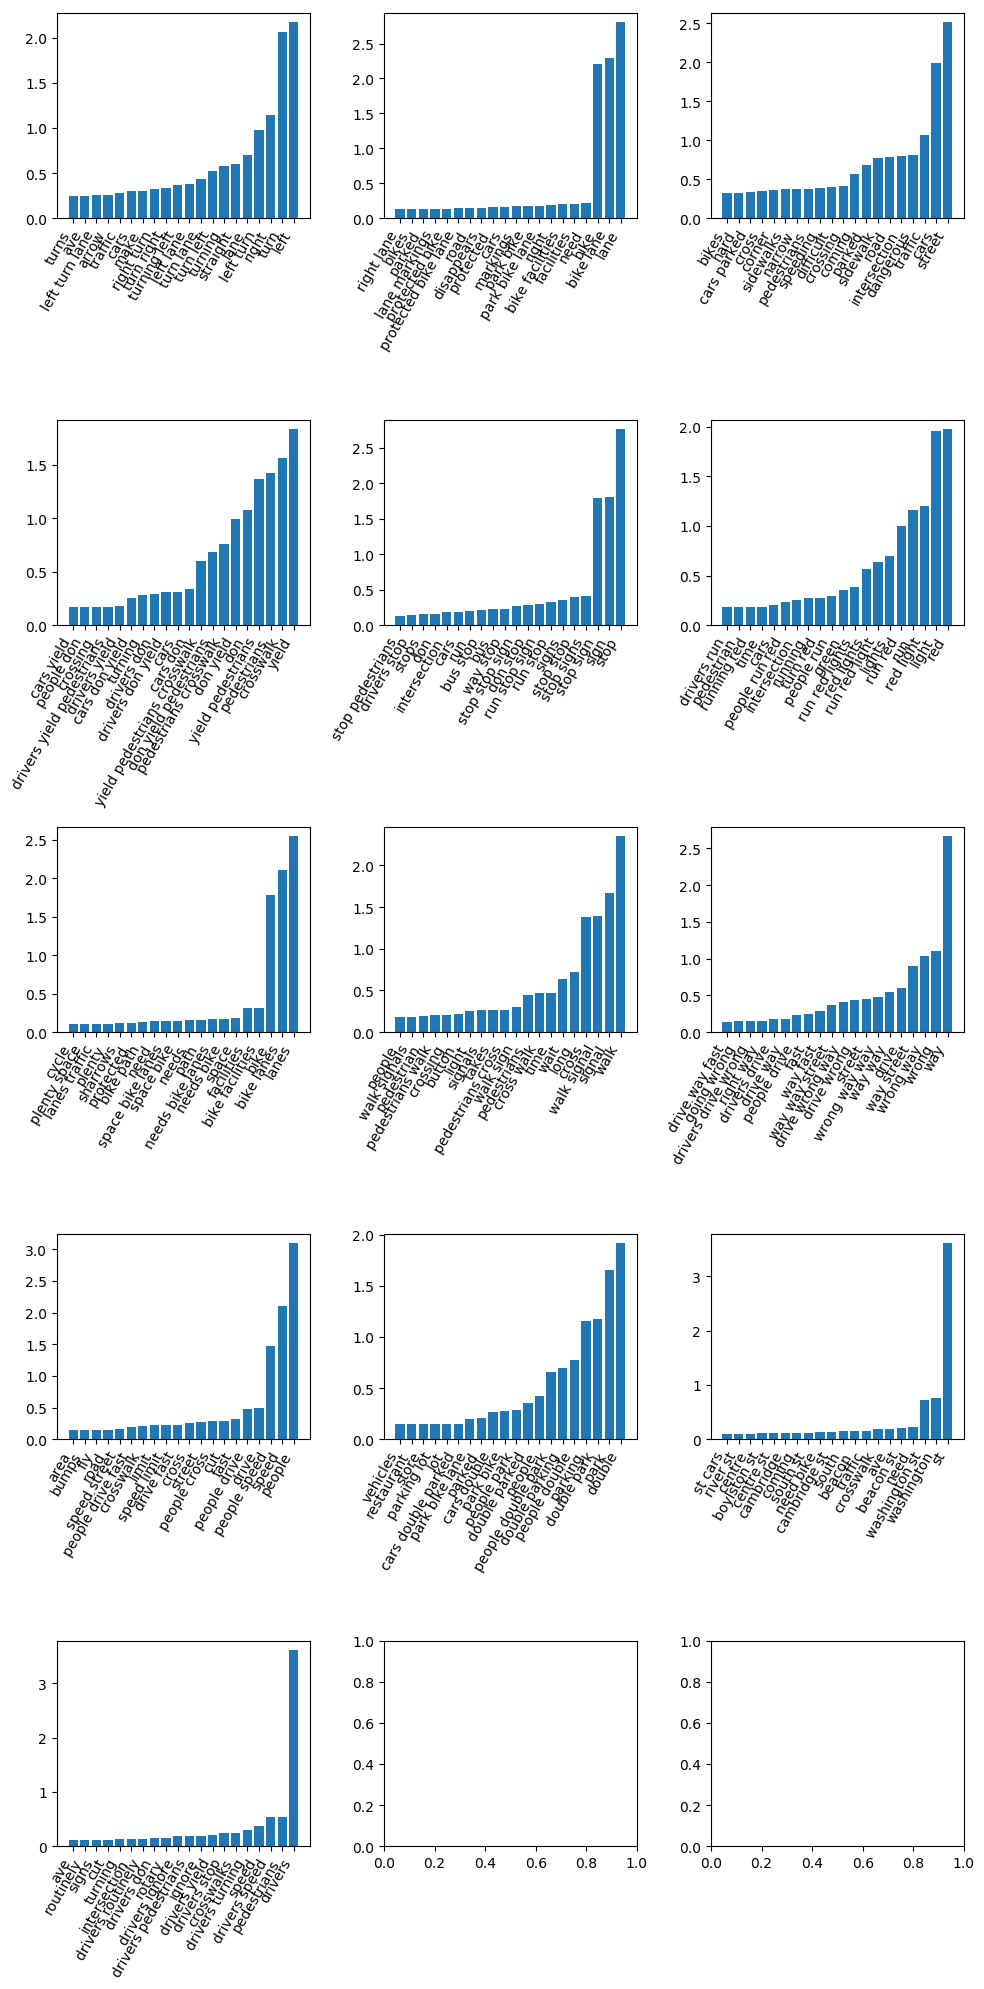

In [77]:
# Topics Visualize For NMF
feature_names = np.array(tfidf_feature_names)
n_components = 13
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 20))
for ax, coef in zip(axes.ravel(), nmf.components_):
    plot_important_features_sub(coef, feature_names, top_n=20, ax=ax)    
plt.tight_layout()

In [78]:
# K-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=13, random_state=0)
kmeans.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [79]:
kmeans_predict=kmeans.labels_
adjusted_rand_score(target,kmeans_predict)

0.077422030352652382

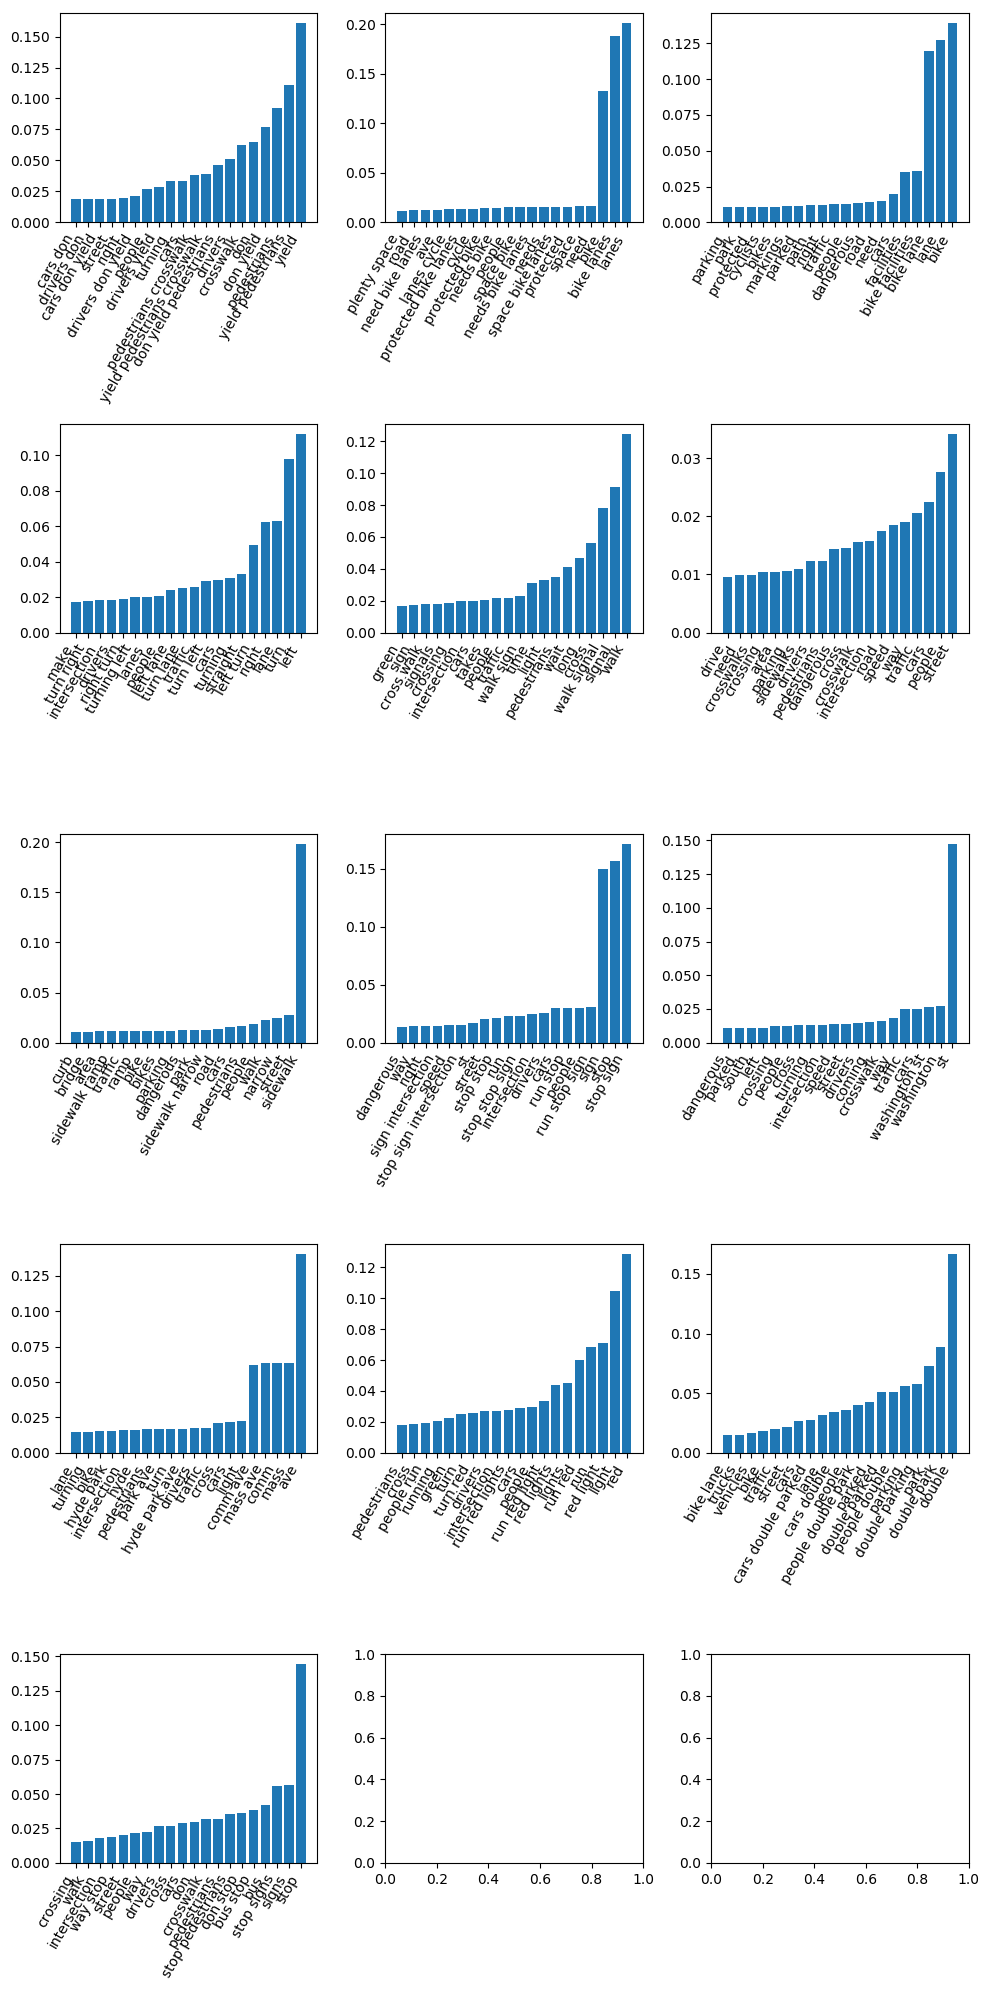

In [80]:
# Visualize K-means Center
feature_names = np.array(tfidf_feature_names)
n_components = 13
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 20))
for ax, coef in zip(axes.ravel(), kmeans.cluster_centers_):
    plot_important_features_sub(coef, feature_names, top_n=20, ax=ax)    
plt.tight_layout()

### Topics that match well with some of the ground truth labels:
Some topics can be matched to orginal label, for example:

- Topic4 matches origin class `people double park their vehicles`
- Topic6 seems match original label `people don't yield while turning`

# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.

The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


In [81]:
# check document with assigned label
topic_doc ={}
for i in range(13):
    topic_name = "topic"+str(i+1)
    topic_doc[topic_name]=[]

for doc_id, topic_dist in enumerate(result_NMF):
    topic_order=topic_dist.argsort()[::-1]
    topic_name = "topic"+str(topic_order[0]+1)
    topic_doc[topic_name].append(text[doc_id])
    
for d in topic_doc:
    print(d, len(topic_doc[d]))
    
# topic_doc['topic12']

In [84]:
text_train_rl_nmf, text_test_rl_nmf, target_train_rl_nmf, target_test_rl_nmf = train_test_split(
    text, NMF_predic, stratify=NMF_predic, random_state=45)

In [85]:
vect = CountVectorizer(stop_words='english', token_pattern=r"\b\w+\b")
text_train_vect_rl_nmf = vect.fit_transform(text_train_rl_nmf)
text_test_vect_rl_nmf = vect.transform(text_test_rl_nmf)

### F1 Score after Re-assign Label

In [86]:
lr_rl_nmf = LogisticRegressionCV().fit(text_train_vect_rl_nmf, target_train_rl_nmf)
pred_rl_nmf = lr_rl_nmf.predict(text_test_vect_rl_nmf)
f1_score(target_test_rl_nmf, pred_rl_nmf, average='macro')

0.8508581467413715

In [87]:
idx = range(13)
label = ['problems on turns', "bike lane don't exist or need improvement", 'dangerous sidewalk/intersection',
         'problems on yielding', 'stop sign', 'traffic light',
         "bike facilities don't exist or need improvement", 
         'walk signal', "wrong behaviors on street",
         'people speed', 'parking', 'request for washington/beacon st', 
         "Drivers dangerous behaviors"]
label_map = pd.DataFrame({'idx': idx, 'label': label})

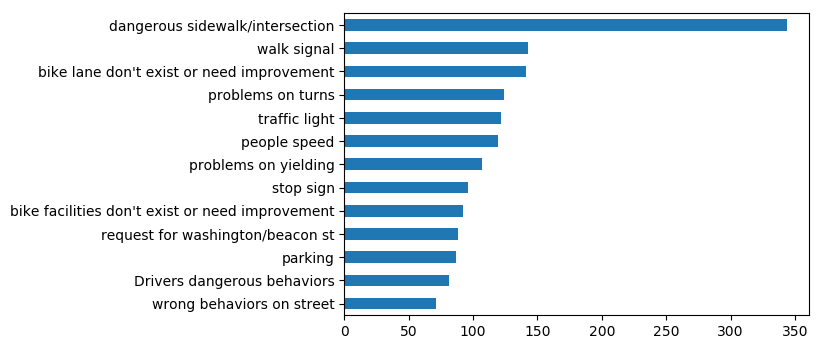

In [88]:
pd.DataFrame({'idx': pred_rl_nmf}).merge(label_map, how='left').label.value_counts(ascending=True).plot(kind='barh')

## Relabel "Others"

In [89]:
index_other=[i for i,j in enumerate(target) if j=='of something that is not listed here']
target_array=np.asarray(target)
text_array=np.asarray(text)

In [90]:
text_array_other=text_array[index_other]

In [91]:
# NMF on other
nmf = NMF(n_components=3, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

tf_other  = tfidf_vectorizer.fit_transform(text_array_other)

result_nmf_other=nmf.fit_transform(tf_other)

In [92]:
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tf_feature_names, 20)


Topic No.1:
stop 1.11 | pedestrians 1.07 | cross 1.02 | light 0.93 | walk 0.9 | crosswalk 0.83 | cars 0.83 | intersection 0.78 | traffic 0.75 | street 0.54 | people 0.53 | sign 0.51 | crossing 0.51 | signal 0.49 | st 0.47 | pedestrian 0.45 | don 0.44 | dangerous 0.44 | yield 0.4 | lights 0.39 | 

Topic No.2:
lane 2.1 | left 1.54 | turn 1.32 | right 1.03 | straight 0.74 | lanes 0.72 | cars 0.53 | bike 0.48 | people 0.35 | drivers 0.34 | traffic 0.31 | turning 0.29 | ave 0.25 | beacon 0.23 | middle 0.23 | st 0.23 | going 0.22 | markings 0.2 | turns 0.19 | signage 0.19 | 

Topic No.3:
way 2.58 | wrong 1.38 | street 1.08 | drive 0.92 | people 0.62 | drivers 0.33 | road 0.3 | narrow 0.25 | parking 0.22 | going 0.19 | direction 0.19 | regularly 0.15 | cars 0.14 | driving 0.14 | park 0.13 | st 0.13 | sides 0.11 | lot 0.11 | pass 0.1 | traffic 0.1 | 


In [93]:
nmf_predic_other=[]
for doc_id, topic_dist in enumerate(result_nmf_other):
    print('\nComment No.%d:' % int(doc_id))
    topic_order=topic_dist.argsort()[::-1]
    print(topic_order)
    nmf_predic_other.append(topic_order[0])


Comment No.0:
[1 0 2]

Comment No.1:
[0 1 2]

Comment No.2:
[0 1 2]

Comment No.3:
[1 2 0]

Comment No.4:
[0 2 1]

Comment No.5:
[1 2 0]

Comment No.6:
[0 1 2]

Comment No.7:
[1 2 0]

Comment No.8:
[0 2 1]

Comment No.9:
[0 2 1]

Comment No.10:
[0 1 2]

Comment No.11:
[2 1 0]

Comment No.12:
[0 1 2]

Comment No.13:
[0 2 1]

Comment No.14:
[0 1 2]

Comment No.15:
[0 2 1]

Comment No.16:
[2 0 1]

Comment No.17:
[1 0 2]

Comment No.18:
[0 2 1]

Comment No.19:
[1 0 2]

Comment No.20:
[2 0 1]

Comment No.21:
[0 2 1]

Comment No.22:
[0 2 1]

Comment No.23:
[0 2 1]

Comment No.24:
[0 2 1]

Comment No.25:
[0 1 2]

Comment No.26:
[0 2 1]

Comment No.27:
[1 0 2]

Comment No.28:
[1 0 2]

Comment No.29:
[1 0 2]

Comment No.30:
[2 1 0]

Comment No.31:
[0 1 2]

Comment No.32:
[0 2 1]

Comment No.33:
[0 2 1]

Comment No.34:
[1 2 0]

Comment No.35:
[2 1 0]

Comment No.36:
[1 0 2]

Comment No.37:
[0 1 2]

Comment No.38:
[0 2 1]

Comment No.39:
[0 1 2]

Comment No.40:
[2 0 1]

Comment No.41:
[1 0 2]

C

In [94]:
target_array[index_other]=nmf_predic_other

In [95]:
# Find a meaningful topic for label 0
index_0=[i for i,j in enumerate(target_array) if j=='0']
print (text_array[index_0])
target_array[index_0]=["poor facilities or bad behaviors on the crosswalk and intersection"]*len(index_0)

['This intersection is very confusing.'
 "A lot of the issues apply. Too much traffic goes through this intersection. Waits are too long for walkers between lights. Bikers, drivers and walkers all cross when they are not given permissions via traffic patterns so there a lot of 'close calls'."
 'There is so much wrong with this intersection. Double parking, not yielding when going straight, not yielding when turning, low visibility, people run red lights, etc.'
 'Conflict area between bikes transitioning from bike path to roadway have to travel through heavy pedestrian traffic'
 'No crosswalk, cars zoom through pedestrian area.'
 'Pedestrians frequently cross Thomson Pl against the lights (i.e., crossing in the small interval when drivers have a green light to enter Congress from Thomson).'
 'No traffic light for cars coming from Storrow means traffic gets backed up. People often try to make this road into 2 lanes when approaching Comm Ave, which makes the problem worse.'
 'BTD-Boston P

In [96]:
# Find a meaningful topic for label 1
index_1=[i for i,j in enumerate(target_array) if j=='1']
print (text_array[index_1])
target_array[index_1]=["Lane markings and traffic light Issue"]*len(index_1)

[ "This intersection is dangerous. Cars don't follow the lane markings (ie go straight while in turn lane) so it's nearly impossible to safely position yourself on a bike. In a car, people are trying to move over/it's unclear where people are going."
 'People turn from both the middle lane (not a turn lane) and from the actual turn lane. Just yesterday saw two cars in a row do it and almost witnessed a car accidents and walkers be hit.'
 'Parking is permitted on both sides of Navarre Street.  Cars park right on the corner of Wilmot and Navarre.  In the event that an emergency vehicle (e;g; fire truck) need to access Wilmot Street they would not be able to make the turn'
 "People (including Silver Line buses) turn right onto Kneeland from the Surface Rd's center lane. Have already seen one accident and have observed many close calls."
 'The valet parking for the hotel is located here - people double park and frequently cones marking the valet zone are placed in the bike lane'
 'left tur

In [97]:
# Find a meaningful topic for label 2
index_2=[i for i,j in enumerate(target_array) if j=='2']
print (text_array[index_2])
target_array[index_2]=["Others"]*len(index_2)

['People zoom down the wrong way on a ONE WAY street.'
 'Bay street hosts too many hookers late at night also there have been frequent muggings along this stretch. a larger police presence and on street camera would give more security to the whole neighborhood.'
 'This is a ONE WAY STREET that, during rush hour, drivers disobey signage and use it for two-way traffic to avoid American Legion Hwy. This is dangerous and the street (Paine St) could use more signage indicating that it is a one-way.'
 'Drivers routinely drive the wrong way down the one way street. Cars are often parked in the wrong direction.'
 'Selected other because Sullivan is all of the above.  Looking forward to a reconstruction plan that replaces the entire circle with something more human scaled.'
 'There is very often a truck here parked at a business here in a way that the trailer blocks half of the road. Reduces visibility for cars and very dangerous.'
 "It's pretty difficult for a new cyclist or runner to find the

In [98]:
pd.DataFrame(target_array)[0].unique()

array(["bike facilities don't exist or need improvement",
       'Lane markings and traffic light Issue',
       "people don't yield while going straight",
       'it’s hard for people to see each other',
       "people don't yield while turning",
       'poor facilities or bad behaviors on the crosswa',
       'the wait for the "Walk" signal is too long',
       'there are no sidewalks or they need maintenance',
       'people cross away from the crosswalks',
       'people double park their vehicles', 'people speed',
       'people run red lights / stop signs', 'Others',
       "there's not enough time to cross the street",
       'the roadway surface needs maintenance'], dtype=object)

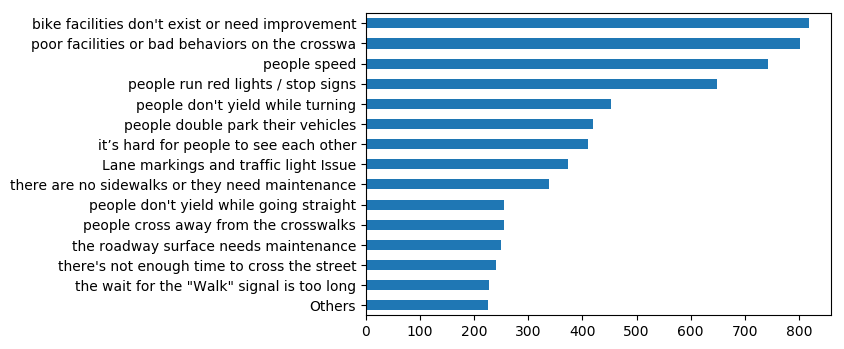

In [99]:
pd.DataFrame(target_array)[0].value_counts(ascending=True).plot(kind='barh')

In [100]:
text_train_tm, text_test_tm, target_train_tm, target_test_tm = train_test_split(text, target_array, 
                                                                                stratify=target_array, random_state=45)

In [101]:
target_train_tm

array(['people cross away from the crosswalks',
       "people don't yield while going straight",
       'Lane markings and traffic light Issue', ..., 'people speed',
       'poor facilities or bad behaviors on the crosswa',
       'the roadway surface needs maintenance'], 
      dtype='<U47')

In [102]:
pipe_ng = make_pipeline(CountVectorizer(min_df=2, ngram_range=(1, 3),stop_words='english', token_pattern=r"\b\w+\b"), LogisticRegressionCV())
pipe_ng.fit(text_train_tm,target_train_tm)

Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words='english...2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

### F1 Score After Split "of something that is not listed here" Type

In [103]:
pred=pipe_ng.predict(text_test_tm)
f1_score(target_test_tm, pred, average='macro')

0.52808824977809943

In [104]:
def task2():
    vect = CountVectorizer(stop_words='english', token_pattern=r"\b\w+\b")
    text_train_vect = vect.fit_transform(text_train)
    text_test_vect = vect.transform(text_test)
    lr = LogisticRegressionCV().fit(text_train_vect, target_train)
    pred = lr.predict(text_test_vect)
    return f1_score(target_test, pred, average='macro')

assert task2()>=0.51789988616023508

In [105]:
def task3():
    vect = CountVectorizer(min_df=2,ngram_range=(1, 3),stop_words='english', token_pattern=r"\b\w+\b")
    text_train_vect = vect.fit_transform(text_train)
    text_test_vect = vect.transform(text_test)
    lr = LogisticRegression(C=1).fit(text_train_vect, target_train)
    pred = lr.predict(text_test_vect)
    return f1_score(target_test, pred, average='macro')

assert task3() >=0.5845905444936866

In [106]:
def task5_lda():

    lda = LatentDirichletAllocation(n_topics=13, max_iter=5,
                                learning_method='online',
                                random_state=0)
    tf_vectorizer = CountVectorizer(max_df=0.95,min_df=2,                               
                                stop_words='english')
    tf = tf_vectorizer.fit_transform(text)
    result_lda=lda.fit_transform(tf)
    lda_predic=[]
    for doc_id, topic_dist in enumerate(result_lda):        
        topic_order=topic_dist.argsort()[::-1]        
        lda_predic.append(topic_order[0])

    return adjusted_rand_score(target,lda_predic)

assert task5_lda() >=0.064159582907047458

In [107]:
def task5_nmf():
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,ngram_range=(1, 3), stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(text)
    nmf = NMF(n_components=13, random_state=1,
              alpha=.1, l1_ratio=.5).fit(tfidf)
    result_NMF=nmf.transform(tfidf)
    NMF_predic=[]
    for doc_id, topic_dist in enumerate(result_NMF):
        topic_order=topic_dist.argsort()[::-1]
        NMF_predic.append(topic_order[0])
    return adjusted_rand_score(target,NMF_predic)

assert task5_nmf() >=0.098662797540306796

In [108]:
def task5_kmeans():
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,ngram_range=(1, 3), stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(text)
    kmeans = KMeans(n_clusters=13, random_state=0)
    kmeans.fit(tfidf)
    kmeans_predict=kmeans.labels_    
    return adjusted_rand_score(target,kmeans_predict)

assert task5_kmeans() >=0.083613080061473166

In [109]:
def task6_newlabel():
    vect = CountVectorizer(stop_words='english', token_pattern=r"\b\w+\b")
    text_train_vect_rl_nmf = vect.fit_transform(text_train_rl_nmf)
    text_test_vect_rl_nmf = vect.transform(text_test_rl_nmf)
    lr_rl_nmf = LogisticRegressionCV().fit(text_train_vect_rl_nmf, target_train_rl_nmf)
    pred_rl_nmf = lr_rl_nmf.predict(text_test_vect_rl_nmf)
    return f1_score(target_test_rl_nmf, pred_rl_nmf, average='macro')

assert task6_newlabel()>=0.85577176150018519

In [110]:
def task6_splitother():
    pipe_ng = make_pipeline(CountVectorizer(min_df=2, ngram_range=(1, 3),stop_words='english', token_pattern=r"\b\w+\b"), LogisticRegressionCV())
    pipe_ng.fit(text_train_tm,target_train_tm)
    pred=pipe_ng.predict(text_test_tm)
    return (f1_score(target_test_tm, pred, average='macro'))

assert task6_splitother()>=0.57319896578997331

# Extra Credit [Up to +20 points]

Use a word embedding representation like word2vec for step 3 and or step 6. 

In [111]:
# Add your code for extra credit here. You may use multiple cells.

### Doc2Vec with gensim

In [113]:
import gensim
import pickle
from sklearn.linear_model import LogisticRegression

def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [115]:
# task3 model
    
train_corpus = list(read_corpus(text_train))
test_corpus = list(read_corpus(text_test, tokens_only=True))

model = gensim.models.doc2vec.Doc2Vec(size=300, min_count=2, iter=55)
model.build_vocab(train_corpus)


model.train(train_corpus, total_examples=model.corpus_count)

with open("doc2vec_300.pickle", "wb") as f:
    pickle.dump(model, f, -1)
    
vectors = [model.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]   

X_train = np.vstack(vectors)

test_vectors = [model.infer_vector(test_corpus[doc_id])
                for doc_id in range(len(test_corpus))]   

X_val = np.vstack(test_vectors)

lr = LogisticRegression(C=100).fit(X_train, target_train)
pred = lr.predict(X_val)
f1_score(target_test, pred, average='macro')

0.25529159905193655

In [120]:
# task6 model
    
train_corpus = list(read_corpus(text_train_rl_nmf))
test_corpus = list(read_corpus(text_test_rl_nmf, tokens_only=True))

model = gensim.models.doc2vec.Doc2Vec(size=300, min_count=2, iter=55)
model.build_vocab(train_corpus)

model.train(train_corpus, total_examples=model.corpus_count)

with open("doc2vec_300.pickle", "wb") as f:
    pickle.dump(model, f, -1)
    
vectors = [model.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]   

X_train = np.vstack(vectors)

test_vectors = [model.infer_vector(test_corpus[doc_id])
                for doc_id in range(len(test_corpus))]   

X_val = np.vstack(test_vectors)


lr = LogisticRegression(C=100).fit(X_train, target_train_rl_nmf)
pred = lr.predict(X_val)
f1_score(target_test_rl_nmf, pred, average='macro')

0.34782085511083299